In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import os
import seaborn as sns
from tqdm.notebook import tqdm
from itertools import product

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from flymazerl.agents.classical import *
from flymazerl.gym.environment import ymaze_baiting,ymaze_static
from flymazerl.utils import generate_params_from_fits,get_schedule_histories, get_schedule_values,get_agent_value_history
from flymazerl.utils import generate_random_schedule_with_blocks
from scipy import stats
import gym
import pickle

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

def pvalue_to_stars(pvalue):
    if pvalue < 0.0001:
        return '****'
    elif pvalue < 0.001:
        return '***'
    elif pvalue < 0.01:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return 'ns'

def pairedCohensD(x,y):
    """ Calculate the paired cohens d for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    return (np.mean(x-y) / np.std(x-y,ddof=1))

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

def pairedRankBiserialCorrelation(x,y):
    """ Calculate the paired rank biserial correlation for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    # calculate the signed rank
    signed_rank = np.sign(x-y)*stats.rankdata(np.abs(x-y))
    # get sum of positive and negative ranks
    pos_rank = np.sum(signed_rank[signed_rank>0])
    neg_rank = -np.sum(signed_rank[signed_rank<0])
    # calculate the proportion of positive and negative ranks
    pos_prop = pos_rank/(pos_rank+neg_rank)
    neg_prop = neg_rank/(pos_rank+neg_rank)
    # calculate the difference in proportion
    return pos_prop-neg_prop

def delta_to_effect(delta):
    """ Convert a cliffs delta to effect size """
    delta = np.abs(delta)
    if delta < 0.147:
        return 'neg'
    elif delta < 0.33:
        return '^'
    elif delta < 0.474:
        return '^^'
    elif delta > 0.474:
        return '^^^'
    else:
        return ''

def d_to_effect(d):
    """ Convert a Cohen's d to effect size """
    d = np.abs(d)
    if d < 0.2:
        return 'neg'
    elif d < 0.5:
        return '^'
    elif d < 0.8:
        return '^^'
    elif d > 0.8:
        return '^^^'
    else:
        return ''

def r_to_effect(r):
    """ Convert a rank biserial correlation to effect size according to Funder (2019)"""
    r = np.abs(r)
    if r < 0.1:
        return 'neg'
    elif r < 0.3:
        return '^'
    elif r < 0.4:
        return '^^'
    elif r > 0.4:
        return '^^^'
    else:
        return ''

def smoothen(x,width):
    if len(x.shape) == 1:
        # check if the first index is a number
        if isinstance(x[0],(int,float)):
            # add padding with 0.5 to avoid edge effects
            x = np.concatenate([np.ones(width-1)*0.5, x])
            # convolve with a boxcar
            x = np.convolve(x, np.ones(width)/width, mode='valid')
            return x
        else:
            xs = []
            for x_ in x:
                xs.append(smoothen(x_,width))
            return np.array(xs)
    elif len(x.shape) == 2:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    elif len(x.shape) == 3:
        xs = []
        for i in range(x.shape[0]):
            xs.append(smoothen(x[i],width))
        return np.array(xs)
    else:
        raise ValueError("x must be 1, 2 or 3 dimensional")

model_database = pd.read_csv("../../FlYMazeRL/model_description_rajagopalan.csv")
# filter to only acceptreject models
model_database = model_database[model_database['Variant'] == 'acceptreject']
# generate maps
model_map = {model_database.iloc[i]['Model']:model_database.iloc[i]['ModelAbv'] for i in range(len(model_database))}

In [21]:
# load parameter means and standard deviations
mohanta_means = pd.read_csv('mohanta2022/tables/parameter_means_mohanta.csv',index_col=0)
mohanta_sds = pd.read_csv('mohanta2022/tables/parameter_sds_mohanta.csv',index_col=0)
rajagopalan_means = pd.read_csv('rajagopalan2022/tables/parameter_means_rajagopalan.csv',index_col=0)
rajagopalan_sds = pd.read_csv('rajagopalan2022/tables/parameter_sds_rajagopalan.csv',index_col=0)

In [22]:
# filter only common index and columns
common_index = mohanta_means.index.intersection(rajagopalan_means.index)
common_columns = mohanta_means.columns.intersection(rajagopalan_means.columns)

mohanta_means = mohanta_means.loc[common_index,common_columns]
mohanta_sds = mohanta_sds.loc[common_index,common_columns]
rajagopalan_means = rajagopalan_means.loc[common_index,common_columns]
rajagopalan_sds = rajagopalan_sds.loc[common_index,common_columns]

In [23]:
# calculate the difference in means
diff_means = mohanta_means - rajagopalan_means
# calculate the combined standard deviation
combined_sds = np.sqrt(mohanta_sds**2 + rajagopalan_sds**2)
# calculate the z-score
z_scores = diff_means/combined_sds
# calculate the p-value
p_values = stats.norm.sf(np.abs(z_scores))*2
# apply function on all data
annotations = np.vectorize(pvalue_to_stars)(p_values)

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\numpy\lib\function_base.py:2387: RuntimeWarning: invalid value encountered in pvalue_to_stars (vectorized)
  outputs = ufunc(*inputs)


In [24]:
# apply model map on index
diff_means.index = diff_means.index.map(model_map)

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


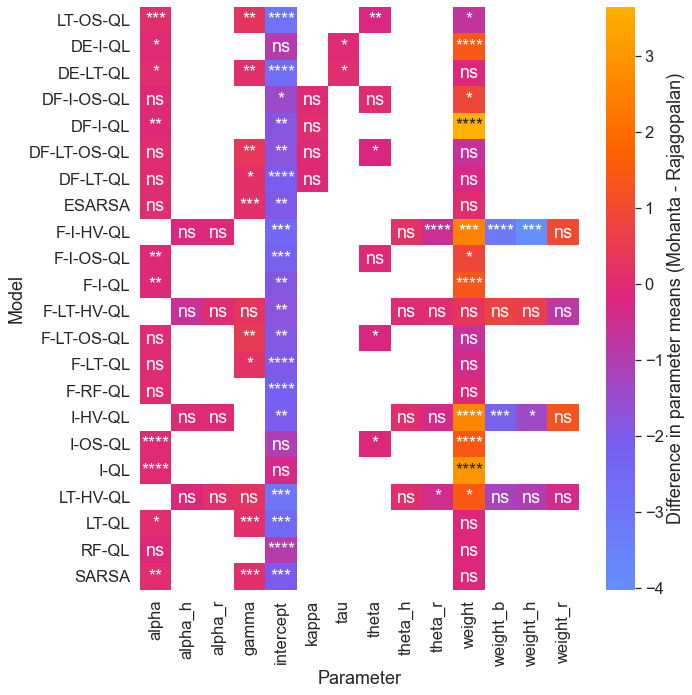

In [31]:
# draw the heatmap
sns.set(font_scale=1.5,style='white')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(diff_means,annot=annotations,fmt='',cmap=cmap,ax=ax,cbar_kws={'label':'Difference in parameter means (Mohanta - Rajagopalan)'})
ax.set_xlabel('Parameter')
ax.set_ylabel('Model')
plt.tight_layout()
plt.savefig('mohantaVsRajagopalan.pdf',bbox_inches='tight')
plt.show()